# ML algorithms can still be effective, especially when dealing with smaller datasets or when interpretability is a priority

## Datasets
Mooney P. Chest X-Ray Images (Pneumonia) [Internet]. 2018. Available from: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/code

# Load Data

In [1]:
import os
import glob as gb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
# Need a paper to choose suitable size
img_size = 256
channel = 1

### Load manually use OpenCV

In [3]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
# function to return the class of the images from its number, 'Normal' ~ 0, and 'PNEUMONIA' ~ 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

### Loading as .npy array

In [4]:
# Loading and saving images as .npy
def load_to_np(dir):
    path = f'../dataset/chest_xray/{dir}/'

    X = []
    y = []
    for folder in  os.listdir(path) : 
        files = gb.glob(pathname= str(path + folder + '/*.jpeg'))
        for file in files: 

            image_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            # resize images to img_size
            resized_img = cv2.resize(image_arr , (img_size, img_size))
            X.append(list(resized_img))
            y.append(code[folder])

    np.save(f'X_{dir}', X)
    np.save(f'y_{dir}', y)

In [5]:
load_to_np('train')

In [6]:
load_to_np('test')

### Loading the .npy files as numpy arrays

In [7]:
# X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

In [8]:
# loaded_X_train[0][0]

In [9]:
# the shape return dimensions of X_train, we have 5216 images
print(loaded_X_train.shape)

(5216, 256, 256)


In [10]:
print(loaded_X_test.shape)

(624, 256, 256)


In [11]:
# y_train and y_test contain the labels of each image, whether 0 'NORMAL' or 1 'PNEUMONIA'
print(loaded_y_train.shape)
print(loaded_y_test.shape)

(5216,)
(624,)


### Investigate pixel value distribution

In [12]:
# function to plot the pixel intensity of each image GRAYSCALE
def plotHistogram(a):
    plt.figure(figsize=(10, 5))

    # print image
    plt.subplot(1, 2, 1)
    plt.imshow(a, cmap='gray')  # Use the 'gray' colormap for grayscale images

    # plot pixel value distribution beside
    histo = plt.subplot(1, 2, 2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')

    n_bins = 30
    plt.hist(a.flatten(), bins=n_bins, lw=0, color='k', alpha=0.5)  # Flatten the single-channel grayscale image

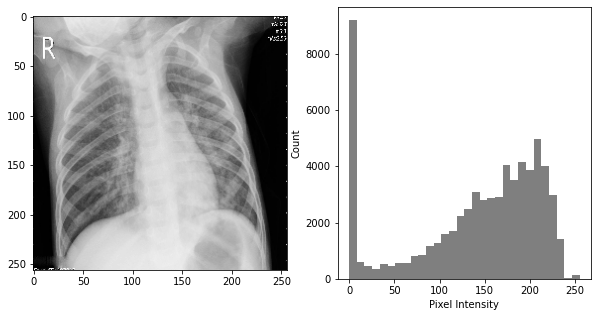

In [13]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

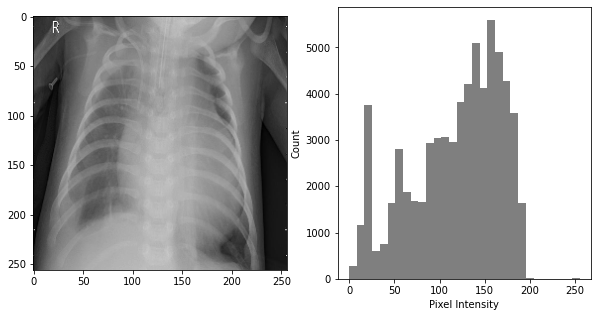

In [14]:
plotHistogram(loaded_X_test[np.random.randint(len(loaded_X_test))])

### Flatten and shuffle train and test sets

In [15]:
# flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((img_size, img_size, channel))])
X_test = loaded_X_test.reshape([-1, np.product((img_size, img_size, channel))])

In [16]:
print(X_train.shape)
print(X_test.shape)

(5216, 65536)
(624, 65536)


In [17]:
y_train = loaded_y_train
y_test = loaded_y_test

In [18]:
from sklearn.utils import shuffle as shf
# shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

# Preprocessing

In [19]:
from sklearn.preprocessing import StandardScaler

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

###  Oversampling using SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

# applying SMOTE to X_train and y_train to generate new samples to overcome the imbalance
from collections import Counter
smote = SMOTE(random_state = 11)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [21]:
print('Before SMOTE : ', Counter(y_train))
print('After SMOTE : ', Counter(y_train_res))

Before SMOTE :  Counter({1: 3875, 0: 1341})
After SMOTE :  Counter({1: 3875, 0: 3875})


In [22]:
# printing X_train and y_train shape after SMOTE
print(X_train_res.shape)
print(y_train_res.shape)

(7750, 65536)
(7750,)


# Model investigation and analysis 

In [23]:
from lazypredict.Supervised import LazyClassifier

# Create a LazyClassifier instance and fit the training data
clf = LazyClassifier(verbose=0,
                        ignore_warnings=True,
                        custom_metric=None,
                        predictions=True,
                        random_state=12,
                        classifiers='all')
LazyClassifier()
# model, predictions = clf.fit(X_train_res, x_test,y_train_res, y_test)
model, predictions = clf.fit(X_train, X_test,y_train, y_test)
model

100%|██████████| 29/29 [2:31:11<00:00, 312.82s/it]   


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.78,0.76,0.76,0.78,58.42
ExtraTreesClassifier,0.79,0.72,0.72,0.76,180.94
ExtraTreeClassifier,0.76,0.72,0.72,0.75,94.33
GaussianNB,0.74,0.71,0.71,0.74,124.42
AdaBoostClassifier,0.75,0.68,0.68,0.72,2026.45
CalibratedClassifierCV,0.75,0.67,0.67,0.72,1719.32
BaggingClassifier,0.74,0.67,0.67,0.71,3164.88
KNeighborsClassifier,0.73,0.65,0.65,0.69,96.01
DecisionTreeClassifier,0.71,0.64,0.64,0.68,695.01


### Save model using joblib package

In [24]:
# import joblib

# # Assuming 'model' is the dictionary returned by LazyClassifier
# for name, classifier in model.items():
#     filename = f"{name}.joblib"
#     joblib.dump(classifier, filename)
#     print(f"Saved {name} classifier model to {filename}")


In [25]:
top_10= model.sort_values(by='Accuracy', ascending=False).head(12)
print(top_10)

                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
ExtraTreesClassifier        0.79               0.72     0.72      0.76   
BernoulliNB                 0.78               0.76     0.76      0.78   
ExtraTreeClassifier         0.76               0.72     0.72      0.75   
CalibratedClassifierCV      0.75               0.67     0.67      0.72   
AdaBoostClassifier          0.75               0.68     0.68      0.72   
GaussianNB                  0.74               0.71     0.71      0.74   
BaggingClassifier           0.74               0.67     0.67      0.71   
KNeighborsClassifier        0.73               0.65     0.65      0.69   
DecisionTreeClassifier      0.71               0.64     0.64      0.68   
DummyClassifier             0.62               0.50     0.50      0.48   
LabelPropagation            0.38               0.50     0.50      0.20   
LabelSpreading              0.38      

### Result visualizations

In [26]:
import plotly.express as px

line = px.line(data_frame= model ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
                rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [27]:
line = px.line(data_frame= model ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
                rangeslider_visible = False)    
line.update_yaxes(title = "Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'TIME TAKEN vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()